<a href="https://colab.research.google.com/github/lwerth/INFO510-public/blob/master/INFO410_hwk4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Analysis of radon measurements:

(a) Fit a linear regression to the logarithms of the radon measurements in Table 7.3, with indicator variables for the three counties and for whether a measurement was recorded on the first floor. Summarize your posterior inferences in nontechnical terms.


In [10]:
# ! pip install pymc3 --upgrade
# ! pip install arviz


     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=2a747fdb8853a5a44405aa363ef65419d971b2139a8f2446e9b48616410800db
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [49]:
#using wine notebook for help
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm
from scipy import stats
import seaborn as sb
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import arviz as az


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *


import theano

In [2]:
radon = pd.read_csv('/content/drive/My Drive/Fall 2020/info410/hwk4/radon.csv')
radon.head(10)

,county,radon,floor
0,Blue Earth,5.0,0
1,Blue Earth,13.0,0
2,Blue Earth,7.2,0
3,Blue Earth,6.8,0
4,Blue Earth,12.8,0
5,Blue Earth,5.8,1
6,Blue Earth,9.5,0
7,Blue Earth,6.0,0
8,Blue Earth,3.8,0
9,Blue Earth,14.3,1


In [42]:
#transform the data & take the log

county_names = radon.county.unique()
radon['county_idx'] = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['county']])
radon['log_radon'] = np.log(radon[['radon']])
n_counties = len(radon.county.unique())
radon



######### Extra Tries ###############
# n_counties = len(radon.county.unique())
# radon['radon'] = radon['radon'].astype(theano.config.floatX)
#encode county as int for ordinal data
# radon[['county']] = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['county']])
# #encode radon into a standard scalar
# radon.log_radon = np.log(radon['radon'])



,county,radon,floor,log_radon,county_idx
0,Blue Earth,5.0,0,1.609438,0
1,Blue Earth,13.0,0,2.564949,0
2,Blue Earth,7.2,0,1.974081,0
3,Blue Earth,6.8,0,1.916923,0
4,Blue Earth,12.8,0,2.549445,0
5,Blue Earth,5.8,1,1.757858,0
6,Blue Earth,9.5,0,2.251292,0
7,Blue Earth,6.0,0,1.791759,0
8,Blue Earth,3.8,0,1.335001,0
9,Blue Earth,14.3,1,2.660260,0


In [44]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, xlabel='floor', ylabel='log_radon', title='radon data and underlying model')
# ax.plot(radon.floor, radon.log_radon, label='radon data')
# ax.plot(radon.floor, true_regression_line, label='true regression line', lw=2.)
# plt.legend(loc=0);

In [16]:
#LIke the wine notebook example, sample the effects of the county and basement

# with pm.Model() as wj_model:
#   #add parameter priors
#   cnty = pm.Normal('cnty', 0, .5, shape = 3)
#   bsmt = pm.Normal('bsmt', 0, .5, shape = 2)

#   alpha = pm.Normal('alpha', 0, .2)
#   sigma = pm.Exponential('sigma', 1)
  
#   mu = alpha + cnty[radon.county.values] + bsmt[radon.floor.values]
#   score = pm.Normal('score', mu = mu, sigma = sigma, observed = radon['radon'])

#   cb_trace = pm.sample(2000, target_accept = .95)
#   cb_sumtab = pm.summary(cb_trace)


Unpooled/non-hierarchical model
>

In [124]:
#unpooled non-hierarchical

with pm.Model() as unpooled_model:
    eps = pm.HalfCauchy('eps', 5)     # Model error

    alpha = pm.Normal('mu', 0, eps) 
    counties = pm.Normal('counties', 0, sd = 100, shape = n_counties)
    b_floor = pm.Binomial('b_floor', 0, 1) #beta - floor slope??

    # floor_slp = pm.Normal('floor_slp', 0, sd=100)

    #alpha + each_county + beta*floor
    mu = alpha + counties[county_idx] + b_floor*radon.floor.values

    # Data likelihood
    y = pm.Normal('y', mu = mu, sd=eps, observed=radon.log_radon)



  
    # y = pm.Normal('y', mu = mu, sigma=a, observed=radon.log_radon)
    # y = pm.Normal('y', radon_model, sd=eps, observed=radon.log_radon) 
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    # radon_est = a[county_idx] + b[county_idx]*radon.floor.values

In [141]:
# Fully pooled; simple logistic regression
with pm.Model() as simple_model:
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 1)
    sigma = pm.HalfCauchy('sigma', 5)
    b_floor = pm.BetaBinomial('b_floor', a, b, radon.floor)
    p = pm.math.invlogit(a + b[county_idx] + b_floor*radon.floor.values)
    radon_levels = pm.Binomial('radon_levels', p=p, sigma=sigma, observed = radon.log_radon)



IndexError: ignored

In [142]:
# with simple_model:
#     trace_simple = pm.sample(30) #, target_accept = 0.8, tune = 1000)
#     summary_simple = pm.summary(trace_simple)

In [125]:
with unpooled_model:
    unpooled_trace = pm.sample(5000)    
    unpooled_sum = pm.summary(unpooled_trace)

unpooled_sum

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [counties, mu, eps]
>Metropolis: [b_floor]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 148 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.016,0.744,-1.391,1.474,0.016,0.012,2041.0,2041.0,2050.0,2463.0,1.0
counties[0],1.869,0.745,0.497,3.372,0.017,0.012,2036.0,2036.0,2045.0,2434.0,1.0
counties[1],1.868,0.745,0.374,3.243,0.017,0.012,2038.0,2038.0,2046.0,2488.0,1.0
counties[2],1.869,0.745,0.416,3.285,0.016,0.012,2044.0,2044.0,2053.0,2434.0,1.0
b_floor,0.000,0.000,0.000,0.000,0.000,0.000,10000.0,10000.0,10000.0,10000.0,NaN
eps,0.764,0.013,0.739,0.789,0.000,0.000,3093.0,3089.0,3104.0,3354.0,1.0


In [111]:

with unpooled_model:
    ppc = pm.sample_posterior_predictive(
        unpooled_trace, var_names=["mu", 'y']
    )

After sampling from the model, we can see that the posterior distribution has a mean of ~1.9

From the summary table, we can see that each county has a similar level of radon, ~1.9 with a 

In [104]:
ppc['y'].shape

(10000, 41, 41)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


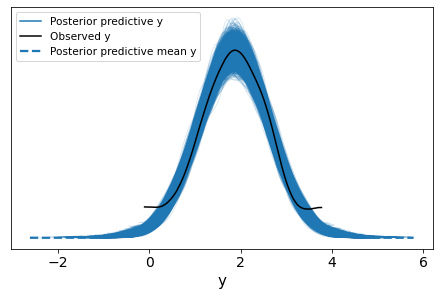

In [105]:
radon_data = az.from_pymc3(unpooled_trace, posterior_predictive=ppc)
az.plot_ppc(radon_data);

In [106]:

print(np.quantile(radon.log_radon, 0.025))
print(np.quantile(radon.log_radon, 0.975))

0.4054651081081644
3.2809112157876537


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f241bd4f128>,
      dtype=object)

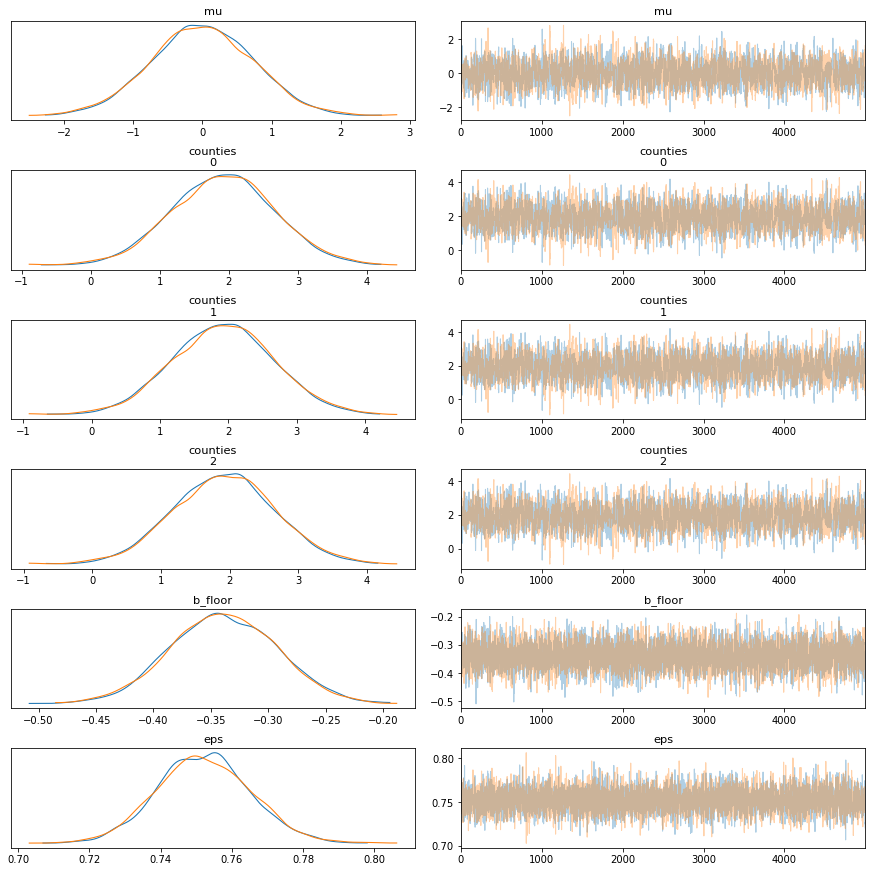

In [107]:
# pm.forestplot(unpooled_trace, var_names = unpooled_trace.varnames.remove('eps'))

az.plot_trace(unpooled_trace) #var_names=["log_radon", "floor"]);

#lef tside parabola - for each parameter value on the x-axis we get a probability on the y-axis 
#that tells us how likely that parameter value is

In [56]:
# plt.figure(figsize=(7, 7))
# plt.plot(radon.log_radon, radon.county, label = 'radon')
# # plt.plot_posterior_predictive_glm(unpooled_trace, samples=100, 
#                                     # label='posterior predictive regression lines')
# # plt.plot(radon.log_radon, true_regression_line, label='true regression line', lw=3., c='y')

# plt.title('Posterior predictive regression lines')
# plt.legend(loc=0)
# plt.xlabel('log_radon')
# plt.ylabel('counties');

Hierarchical model
> 14.1 a)

In [ ]:
#set mu and sd to a fixed value

with pm.Model() as radonH_mod:
  mu_a = pm.Normal('mu_a', mu = 0, sd = 1000**2) #set mu and sd to a fixed value
  sigma_a = pm.HalfCauchy('sigma_a', 5)
  mu_b = pm.Normal('mu_b', mu=0, sd=1000**2)
  sigma_b = pm.HalfCauchy('sigma_b', 5)

  # Intercept for each county, distributed around group mean mu_a
  # plug in a common group distribution for all a and b (which are
   # vectors of length n_counties).

  a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape = n_counties)
  b = pm.Normal('b', mu = mu_b, sd = sigma_b, shape = n_counties)
  
      
  eps = pm.HalfCauchy('eps', 5) #model error (epsilon)
  
  radon_eps = a[county_idx] + b[county_idx] * radon.floor.values
  
  #data likelihood
  radon_likelihood = pm.Normal('radon_likelihood', mu=radon_eps, sd = eps, observed = radon.radon)



In [ ]:
with radonH_mod:
  hierarchical_trace = pm.sample(draws=2000, n_init=1000)
  hierarchical_sumry = pm.summary(hierarchical_trace)
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.
There were 535 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6017536045201989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 907 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6836686869137862, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# pm.forestplot(hierarchical_trace, var_names = hierarchical_trace.varnames.remove('eps'))

hierarchical_sumry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,9.033,0.793,7.952,10.420,0.040,0.029,398.0,364.0,288.0,657.0,1.02
mu_b,-2.601,1.311,-4.869,-0.541,0.144,0.124,83.0,56.0,35.0,97.0,1.07
a[0],9.029,0.287,8.417,9.552,0.018,0.013,262.0,262.0,295.0,99.0,1.05
a[1],9.033,0.302,8.352,9.543,0.025,0.017,150.0,150.0,142.0,132.0,1.02
a[2],9.030,0.301,8.355,9.544,0.019,0.014,248.0,248.0,260.0,109.0,1.01
b[0],-2.654,0.686,-3.758,-1.298,0.133,0.095,26.0,26.0,31.0,218.0,1.06
b[1],-2.667,0.674,-3.824,-1.475,0.133,0.095,26.0,26.0,32.0,136.0,1.06
b[2],-2.643,0.703,-3.888,-1.314,0.107,0.076,43.0,43.0,47.0,179.0,1.05
sigma_a,0.749,1.104,0.057,2.403,0.060,0.043,337.0,337.0,84.0,125.0,1.03
sigma_b,1.138,1.495,0.051,3.416,0.135,0.096,122.0,122.0,37.0,18.0,1.04


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


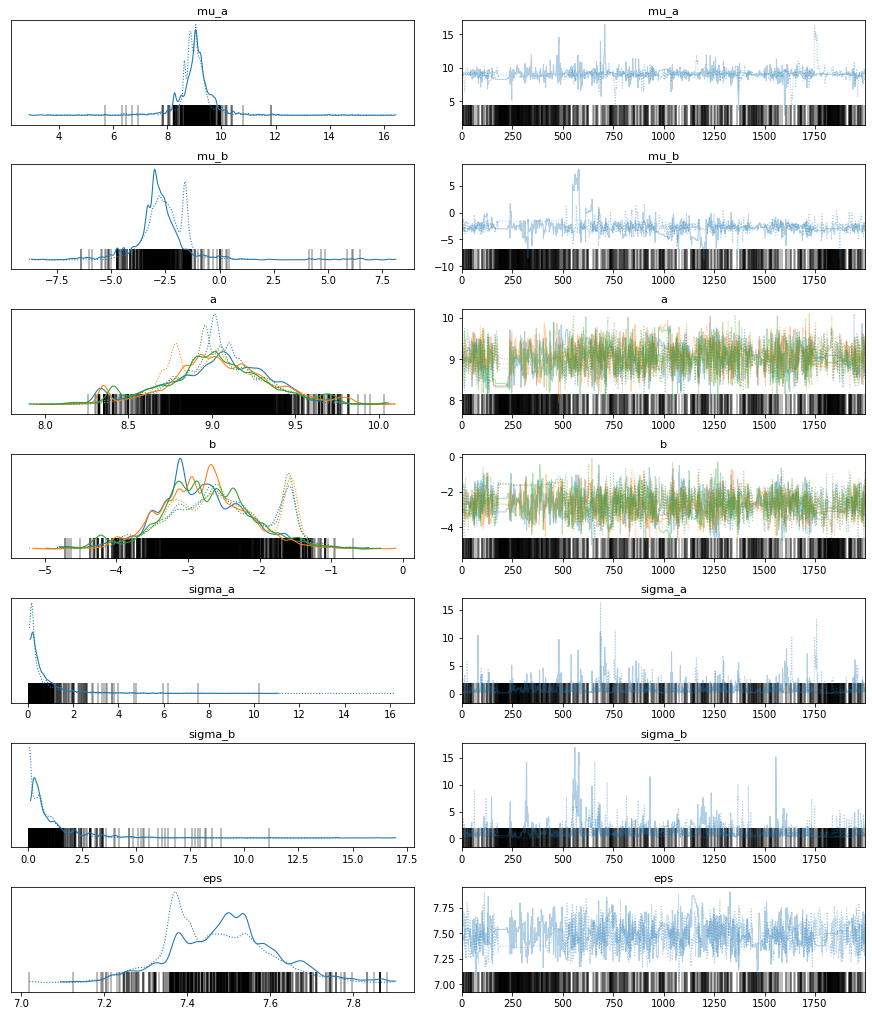

In [ ]:
pm.traceplot(hierarchical_trace);

14.1

>(b) Suppose another house is sampled at random from Blue Earth County. Sketch the posterior predictive distribution for its radon measurement and give a 95% predictive interval. Express the interval on the original (unlogged) scale. (Hint: you must consider the separate possibilities of basement or first-floor measurement.)
